In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy as sc
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

In [2]:
# read in data
#raw_loan_data = pd.read_csv('loan.csv')
#raw_loan_data.shape

In [3]:
# filter for relevant columns
#relevant_cols = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']
# save filtered data to avoid reading large raw data file again
#raw_loan_data[relevant_cols].to_csv('filtered_loan_data.csv', index = False)

In [4]:
# read in filtered data
filtered_loan_data = pd.read_csv('filtered_loan_data.csv')

In [5]:
# sanity check that number of rows has remained constant in filtering
filtered_loan_data.shape

(2260668, 11)

# Part 1: Data Exploration and Evaluation

Part 1 consists of four sections:

#### Section 1A: Handling Missing Values
#### Section 1B: Cleaning Categorical Variables
#### Section 1C: Managing Outliers for Numerical Variables
#### Section 1D: Standardizing Numerical Variables
#### Section 1E: Visualizing Cleaned Data

#### Section 1A: Handling Missing Values

In [6]:
# preview filtered data
filtered_loan_data.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,2500,2500,36 months,13.56,C,55000.0,Dec-2018,18.24,4341,167.02,Current
1,30000,30000,60 months,18.94,D,90000.0,Dec-2018,26.52,12315,1507.11,Current
2,5000,5000,36 months,17.97,D,59280.0,Dec-2018,10.51,4599,353.89,Current
3,4000,4000,36 months,18.94,D,92000.0,Dec-2018,16.74,5468,286.71,Current
4,30000,30000,60 months,16.14,C,57250.0,Dec-2018,26.35,829,1423.21,Current


In [7]:
# count of values by variable
filtered_loan_data.count()

loan_amnt      2260668
funded_amnt    2260668
term           2260668
int_rate       2260668
grade          2260668
annual_inc     2260664
issue_d        2260668
dti            2258957
revol_bal      2260668
total_pymnt    2260668
loan_status    2260668
dtype: int64

In [8]:
# a version of our dataset with no missing values
filtered_loan_data_no_missing = filtered_loan_data.dropna()
filtered_loan_data_no_missing.shape

(2258953, 11)

In [9]:
# missing values are less than 0.1% of data
(filtered_loan_data.shape[0] - filtered_loan_data_no_missing.shape[0]) / filtered_loan_data.shape[0] * 100

0.0758625326673355

Given the very low incidence (< 0.1%) of missing values, we can exclude them from the analysis. If missing values were of higher incidence, then we could impute them using a means or regression method.

#### Section 1B: Cleaning Categorical Variables

In [10]:
numerical_vars = filtered_loan_data_no_missing._get_numeric_data().columns.values
categorical_vars = list(filtered_loan_data_no_missing.columns.difference(numerical_vars))
categorical_vars

['grade', 'issue_d', 'loan_status', 'term']

In [11]:
# summary statistics on categorical variables
filtered_loan_data_no_missing[categorical_vars].describe()

,grade,issue_d,loan_status,term
count,2258953,2258953,2258953,2258953
unique,7,139,9,2
top,B,Mar-2016,Fully Paid,36 months
freq,663120,61979,1041702,1608745


The above summary statistics table suggests that grade, loan status and term are good candidates for conversion to dummy variables (given their relatively small number of unique values) while issue date is not (139 unique values). 

Issue date needs to be coded to capture the information its conveying, an indicator of months since origination.

In [12]:
# code grade, loan status and term as dummies
# in our logistic regression model we will have n-1 dummies for n categories but keep n for now for visualization purposes
filtered_loan_data_cat_fix_1 = pd.get_dummies(filtered_loan_data_no_missing, columns = ['grade', 'loan_status', 'term'])

In [13]:
filtered_loan_data_cat_fix_1.columns.values

array(['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc', 'issue_d',
       'dti', 'revol_bal', 'total_pymnt', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'loan_status_Charged Off', 'loan_status_Current',
       'loan_status_Default',
       'loan_status_Does not meet the credit policy. Status:Charged Off',
       'loan_status_Does not meet the credit policy. Status:Fully Paid',
       'loan_status_Fully Paid', 'loan_status_In Grace Period',
       'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)',
       'term_ 36 months', 'term_ 60 months'], dtype=object)

In [14]:
# format issue date as datetime for subtraction
filtered_loan_data_cat_fix_1['issue_d_clean'] = pd.to_datetime(filtered_loan_data_cat_fix_1['issue_d'], format='%b-%Y')

In [15]:
today_date = datetime.date.today()

In [16]:
# create months since issue varriable
filtered_loan_data_cat_fix_1['months_since_issue'] = ((today_date - filtered_loan_data_cat_fix_1['issue_d_clean'])/np.timedelta64(1, 'M')).astype(int)

In [17]:
# we don't need issue_d anymore
filtered_loan_data_cat_fixed = filtered_loan_data_cat_fix_1[filtered_loan_data_cat_fix_1.columns.difference(['issue_d', 'issue_d_clean'])]
filtered_loan_data_cat_fixed.head()

,annual_inc,dti,funded_amnt,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,...,loan_status_Does not meet the credit policy. Status:Fully Paid,loan_status_Fully Paid,loan_status_In Grace Period,loan_status_Late (16-30 days),loan_status_Late (31-120 days),months_since_issue,revol_bal,term_ 36 months,term_ 60 months,total_pymnt
0,55000.0,18.24,2500,0,0,1,0,0,0,0,...,0,0,0,0,0,12,4341,1,0,167.02
1,90000.0,26.52,30000,0,0,0,1,0,0,0,...,0,0,0,0,0,12,12315,0,1,1507.11
2,59280.0,10.51,5000,0,0,0,1,0,0,0,...,0,0,0,0,0,12,4599,1,0,353.89
3,92000.0,16.74,4000,0,0,0,1,0,0,0,...,0,0,0,0,0,12,5468,1,0,286.71
4,57250.0,26.35,30000,0,0,1,0,0,0,0,...,0,0,0,0,0,12,829,0,1,1423.21


#### Section 1C: Managing Outliers for Numerical Variables

In [18]:
#summarize numerical variables
filtered_loan_data_cat_fixed[numerical_vars].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
count,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06
mean,15043.9,15038.6,13.0921,78051.5,18.8242,16658.9,11827.2
std,9188.07,9186.24,4.83136,112718,14.1833,22945.4,9890.39
min,500,500,5.31,0,-1,0,0
25%,8000,8000,9.49,46000,11.89,5951,4274.47
50%,12900,12850,12.62,65000,17.84,11325,9065.12
75%,20000,20000,15.99,93000,24.49,20247,16712.6
max,40000,40000,30.99,1.1e+08,999,2.90484e+06,63296.9


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BD2C120908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001BD07E4B470>]], dtype=object)

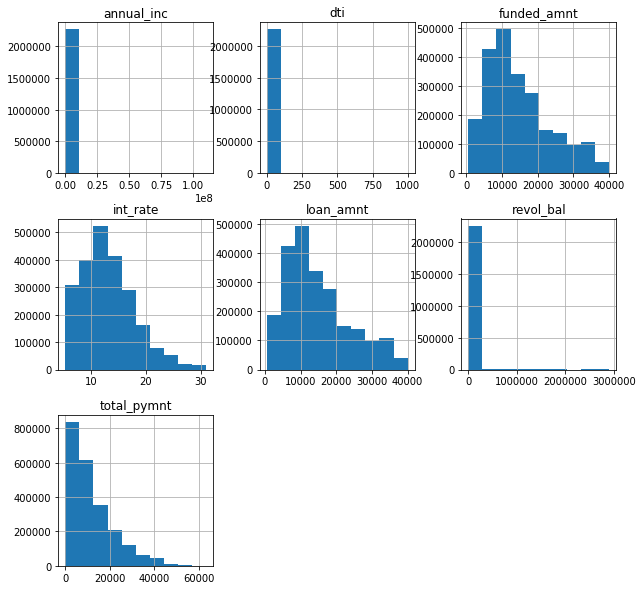

In [19]:
# distributions of numerical variables
filtered_loan_data_cat_fixed[numerical_vars].hist(figsize=(10,10))

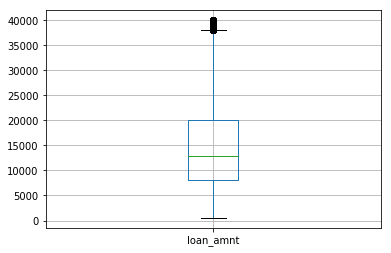

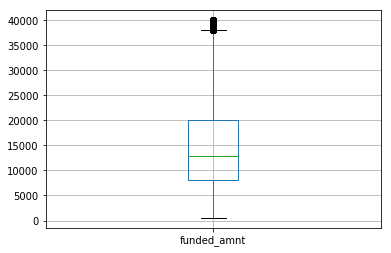

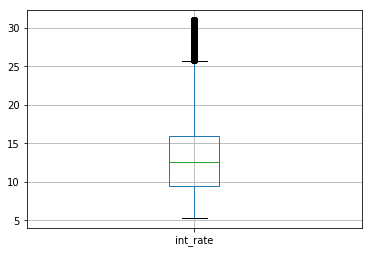

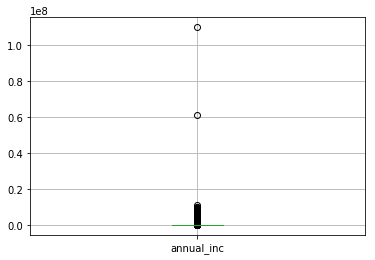

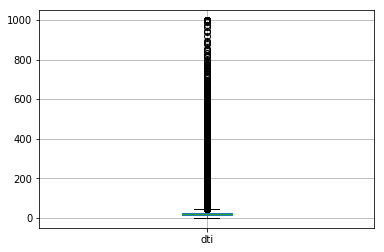

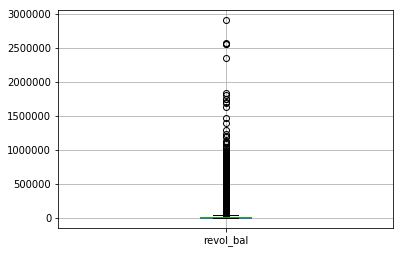

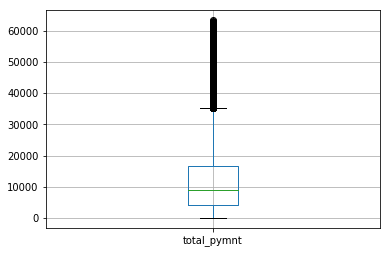

In [20]:
# box plots of each numerical variable
for column in filtered_loan_data_cat_fixed[numerical_vars]:
    plt.figure()
    filtered_loan_data_cat_fixed.boxplot([column])

The pictures above shows the highest incidence of outliers in revolving balance, dti, annual income and total payment. This result is logical in that these variables are most sensitive to individual customer situations and are thus most impacted by outlier customers

In [21]:
# create version of dataset with outliers removed using 1.5 IQR rule
filtered_loan_data_no_outliers = filtered_loan_data_cat_fixed.copy()
for col in numerical_vars:
    Q1 = filtered_loan_data_no_outliers[col].quantile(0.25)
    Q3 = filtered_loan_data_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    filtered_loan_data_no_outliers = filtered_loan_data_no_outliers[(filtered_loan_data_no_outliers[col] >= (Q1-1.5*IQR)) & (filtered_loan_data_no_outliers[col] <= (Q3+1.5*IQR))] 

In [22]:
# droping observations with outliers removes ~ 16% of the data
(filtered_loan_data_cat_fixed.shape[0] - filtered_loan_data_no_outliers.shape[0]) / filtered_loan_data_cat_fixed.shape[0] * 100

16.468691469012413

Given, the relatively large % of the data that is removed when dropping all observations with outliers, we cannot simply remove outliers as they may be a reflect significant underlying features of the data. Instead we will generate a winsorized version of the dataset (5% on each side) and both visualize and test our logistic regression model on the original data, data without outliers and winsorized data. A 5% threshold is chosen as given the high outlier precense in the data set, a relatively high winsorization threshold is needed for winsorization to have the intended effect.

In [23]:
filtered_loan_data_winsorized = filtered_loan_data_cat_fixed.copy()
for col in numerical_vars: 
     filtered_loan_data_winsorized[col] = sc.stats.mstats.winsorize(filtered_loan_data_winsorized[col], limits=0.05)

In [24]:
# now we have three datasets - regular, no outliers and winsorized
filtered_loan_data_regular = filtered_loan_data_cat_fixed.copy()
dfs_list = [filtered_loan_data_regular, filtered_loan_data_no_outliers, filtered_loan_data_winsorized]

In [27]:
filtered_loan_data_regular.dtypes

annual_inc                                                         float64
dti                                                                float64
funded_amnt                                                          int64
grade_A                                                              uint8
grade_B                                                              uint8
grade_C                                                              uint8
grade_D                                                              uint8
grade_E                                                              uint8
grade_F                                                              uint8
grade_G                                                              uint8
int_rate                                                           float64
loan_amnt                                                            int64
loan_status_Charged Off                                              uint8
loan_status_Current      

As numerical variables are on various different scales, it is helpful to standardize them i.e. scale each to have zero mean and a standard deviation of 1. However, before we standardize, we must create a training and test set and use the mean and sd of training data only to keep the test data completely isolated from the training set.

#### Section 1D: Standardize Numerical Data

In [ ]:
# before standardizing split each df into training and test:
for df in dfs_list:
    

#### Section 1D: Visualizing Cleaned Data

C:\ProgramData\OWTools\miniconda\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


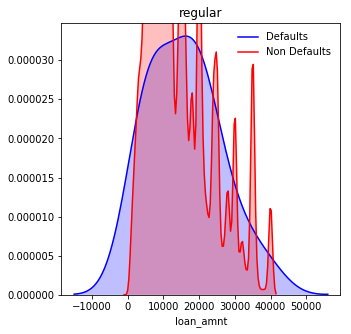

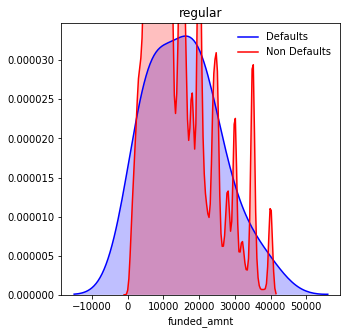

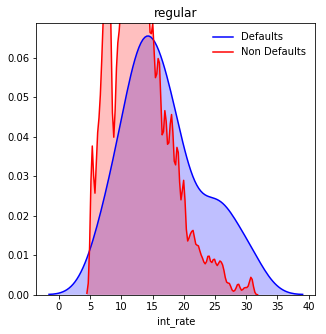

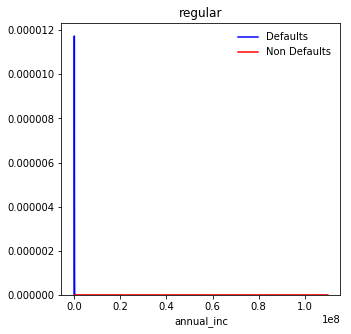

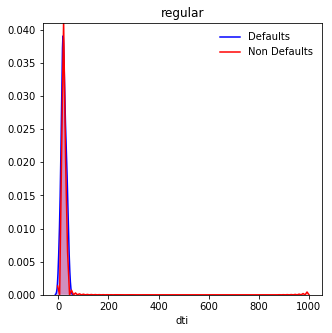

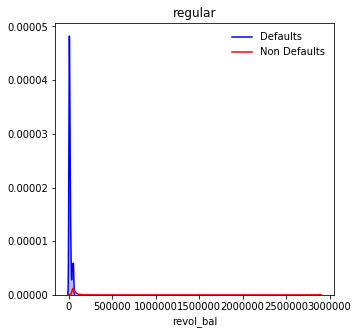

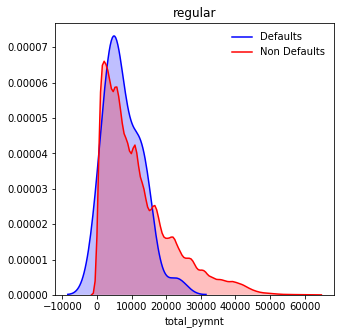

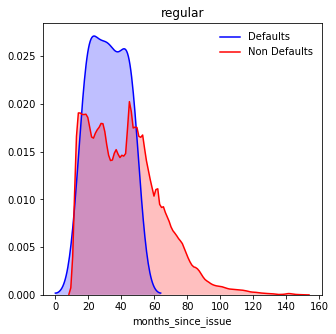

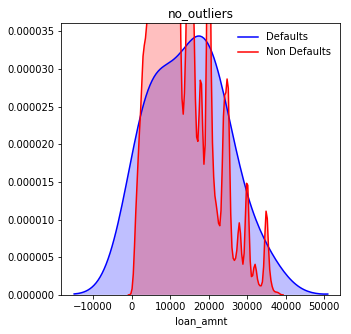

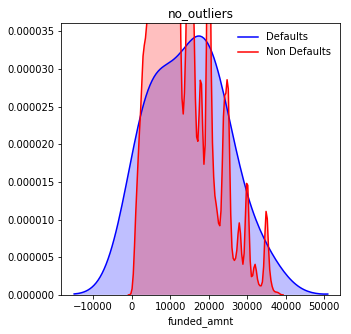

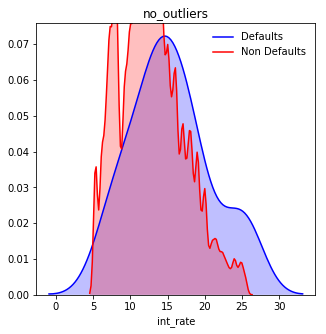

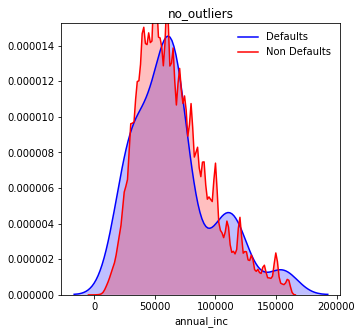

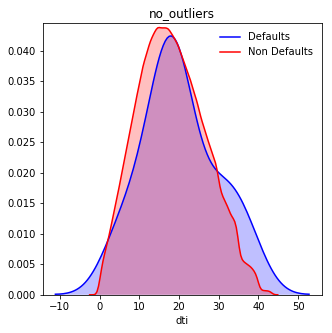

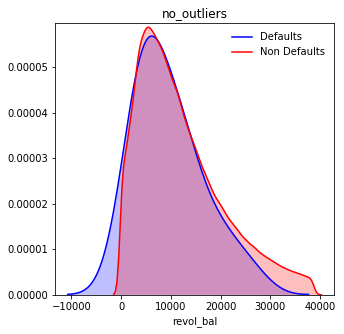

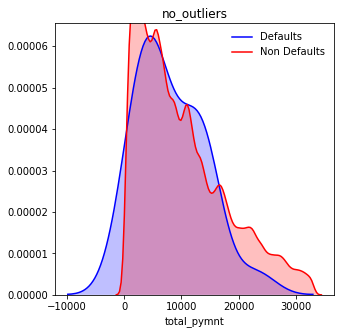

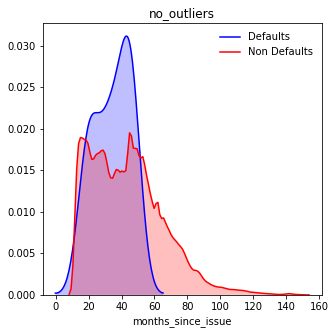

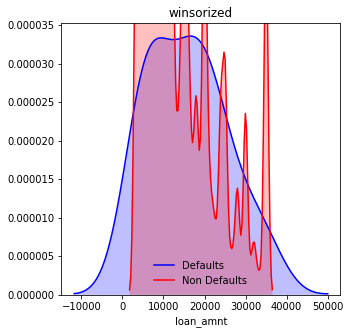

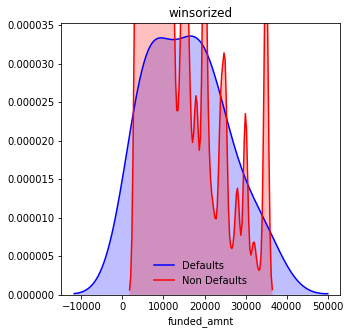

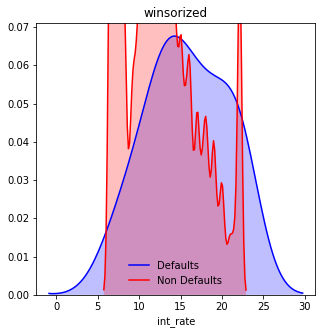

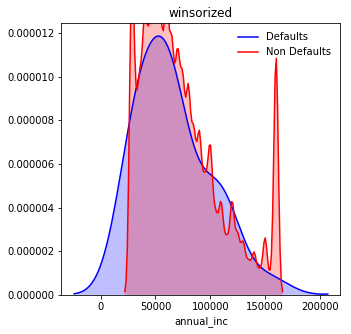

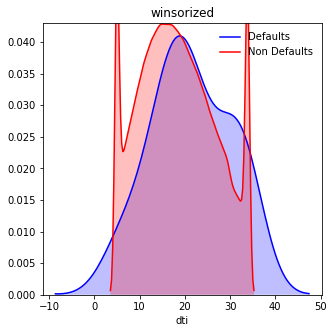

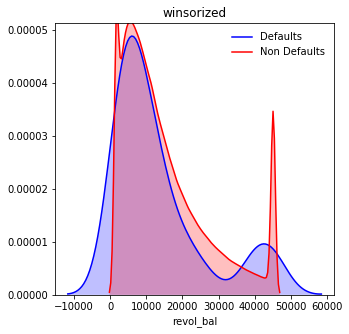

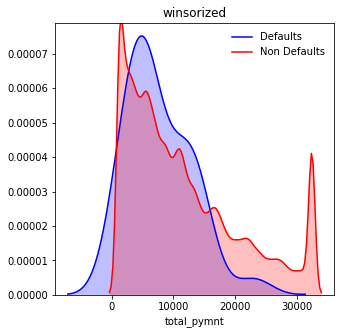

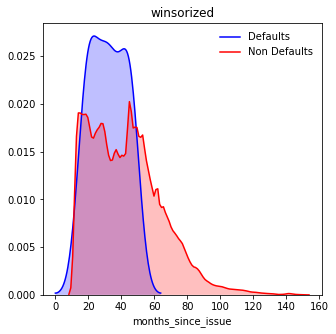

In [32]:
# create kernal density plots that show distribution of each variable by defaults - variable of interest
# plots for continuous variables
continuous_vars = np.append(numerical_vars,'months_since_issue')
for df in dfs_list:
    defaults = df[df['loan_status_Default'] == 1]
    non_defaults = df[df['loan_status_Default'] == 0]
    for ccol in continuous_vars:
        fig, ax = plt.subplots(figsize=(5,5))
        sns.kdeplot(defaults[ccol].values, color = 'blue', label = 'Defaults', shade=True)
        sns.kdeplot(non_defaults[ccol].values, color = 'red', label = 'Non Defaults', shade=True)
        plt.xlabel("%s" % ccol)
        plt.legend(frameon=False, loc='best')
        plot_title = [x for x in globals() if globals()[x] is df][0].split("data_",1)[1]
        plt.title(plot_title)
        plt.